# Image Processing in Python

In this notebook, we will go through some basic image processing in Python!  

Then we'll take a look at a machine learning application called Style Transfer to do some really wild modern image processing.

## 1) Basic  Image Processing and Manipulation

### 1.1 Imports and Data Loading
First, we need to import some packages that provide us with tools for manipulating images. 

We will also need to import a nice image to play with.

In [0]:
!unzip -e HandsOnTech-master.zip

In [0]:
# Import useful packages for image manipulation and plotting
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave

In [0]:
# Import an image to play with
from skimage import data
cat = data.chelsea()

### 1.2 Plotting the image and converting to grayscale
Let's take a look at the image, in both color and grayscale.

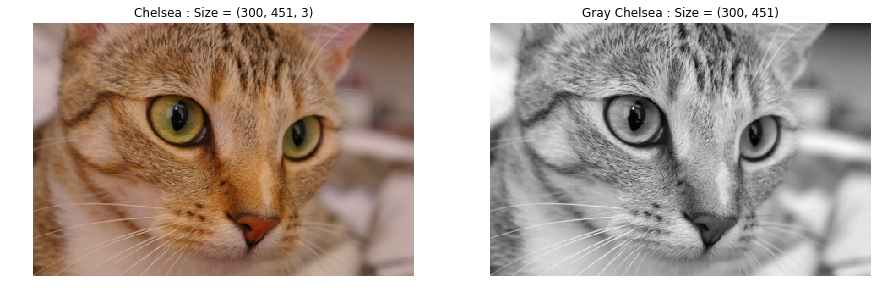

In [72]:
from skimage.color import rgb2grey

# Set up a figure to plot images in
f = plt.figure(1, figsize=(15,5))

# Convert the image to grayscale
gray_cat = (rgb2grey(cat)*255).astype('uint8')

# Display the cat in color!
plt.subplot(121)
plt.imshow(cat)
plt.title('Chelsea : Size = ' + str(cat.shape))
plt.axis('off')

# Display the cat in gray!
plt.subplot(122)
plt.imshow(gray_cat,cmap='gray')
plt.title('Gray Chelsea : Size = ' + str(gray_cat.shape))
plt.axis('off')
plt.show()

Notice how the size of each image is the same, 300 x 451 pixels, but the color image has three separate color channels!

### 1.3 Plotting out the R, G, B channels separately
Each pixel of a digital image is defined by how much of the colors red, green, and blue it contains, which are called "channels". 

For example, a white pixel in uint8 encoding is [255, 255, 255] (full RGB intensity), while a black pixel is [0, 0, 0] (zero RGB intensity), and a red pixel is [255, 0, 0] (full R intensity, zero GB intensity). 

We can split an image into its 3 channels to get an idea of how much of each color is present in each pixel.

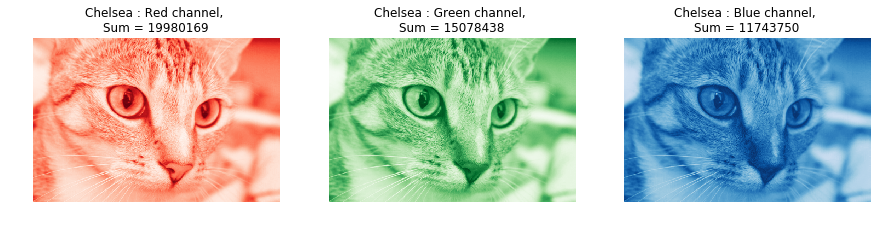

In [74]:
f = plt.figure(1, figsize=(15,5))

# Pull out the number of color channels and give them names
num_c = cat.shape[-1]
colors = ['Red','Green','Blue']

# Plot each color channel as a separate image
for ii, clr in enumerate(colors):
    plt.subplot(1, num_c, ii+1)
    plt.imshow(cat[:, :, ii], cmap=clr+'s_r')
    plt.title('Chelsea : ' + clr + ' channel, \nSum = '+str(np.sum(cat[:, :, ii])))
    plt.axis('off')
plt.show()

### 1.4 Cropping & Flipping
Cropping and flipping is easy - we just have to change the bounds of the pixels to crop, or the order of the rows or columns of the image to flip it. 

**Cropping Images**

In [0]:
# Crop the image to be square
#  - Take a look at the image size from Section 1.2 to remind yourself how many 
#  - pixels the image has in each dimension
# 
#  - Try changing the indices below to center the cat's face within the crop
cat_sq = gray_cat[:, 40:340]

**Flipping Images**

In [0]:
# Flip the cropped image horizontally
cat_sq_flipH = cat_sq[:, ::-1]

# Flip the cropped image vertically
cat_sq_flipV = cat_sq[::-1, :] 

**Plot the square-cropped and flipped versions of the cat image**

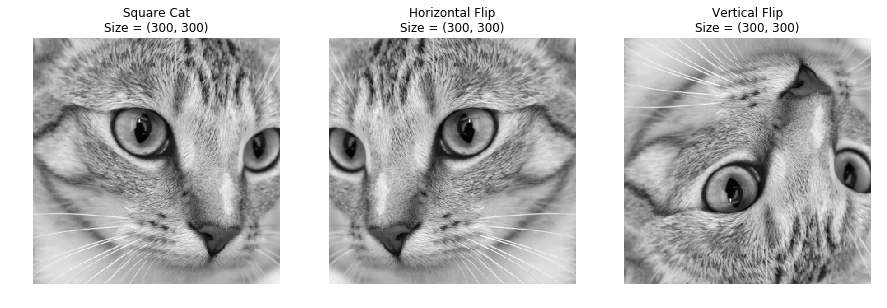

In [79]:
f = plt.figure(1, figsize=(15,5))

plt.subplot(131)
plt.imshow(cat_sq,cmap='gray')
plt.title('Square Cat\nSize = ' + str(cat_sq.shape))
plt.axis('off')

plt.subplot(132)
plt.imshow(cat_sq_flipH,cmap='gray')
plt.title('Horizontal Flip\nSize = ' + str(cat_sq_flipH.shape))
plt.axis('off')

plt.subplot(133)
plt.imshow(cat_sq_flipV,cmap='gray')
plt.title('Vertical Flip\nSize = ' + str(cat_sq_flipV.shape))
plt.axis('off')

plt.show()

### 1.5 Filtering 
A common problem in image processing is removing "noise" - some sort of corruption which makes the image less clean. A popular solution is to implement a filter, which replaces each pixel with the median of the pixels around it.

First we'll corrupt our image with random noise. Then, we'll try to recover the original image by applying a median filter. (You could also try a mean filter and see how the results vary!)

**Import packages for adding noise, measuring image corruption, and filtering**

In [0]:
from skimage.util import random_noise
from skimage.measure import compare_psnr, compare_ssim
from skimage.filters import median

**Add random noise to the cat picture**

Here we add "Salt and Pepper" noise. You can also take a look at some of the [other types of image noise](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.random_noise)

In [0]:
salty_cat_sq = (random_noise(cat_sq, mode='s&p') * 255).astype('uint8')

**Apply a median filter to reduce the noise**

In [0]:
less_salty = median(salty_cat_sq)

**Plot the noisy and filtered images**

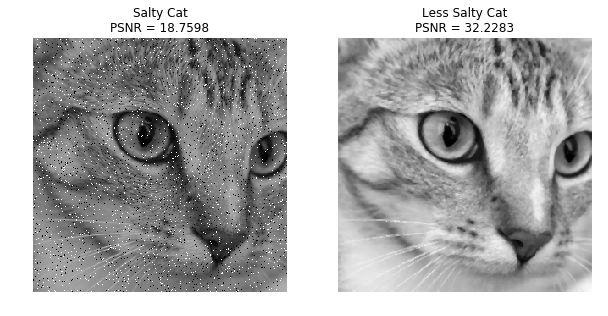

In [84]:
f = plt.figure(1, figsize=(10,5))

plt.subplot(121)
plt.imshow(salty_cat_sq,cmap='gray')
plt.title('Salty Cat\nPSNR = ' + str(np.around(compare_psnr(cat_sq, salty_cat_sq),4)))
plt.axis('off')

plt.subplot(122)
plt.imshow(less_salty,cmap='gray')
plt.title('Less Salty Cat\nPSNR = ' + str(np.around(compare_psnr(cat_sq, less_salty),4)))
plt.axis('off')

plt.show()

In the 'Salty Cat' and 'Less Salty Cat' images above, PSNR means Peak Signal-to-Noise Ratio and is a measure of image corruption. 

>*Question: Judging from the two images above - is a high PSNR good or bad?*

>Answer: 

### 1.6 Implementing different types of filters with Convolution
In the context of image processing, "convolution" is the mathematical operation that performs filtering. Convolution defines each pixel in the new image as a weighted sum of the original pixels in a square region around that pixel. The weights and size of the region define a convolution filter, commonly called a "kernel". Implementing convolution means applying this kernel to every pixel in the original image to create the new image. 
<br>The operation looks like this:
<center>
<img src = "https://cdn-images-1.medium.com/max/1600/0*dRD6PhKOnnCIhz15.jpg" width=350 >
</center>
</br>While the kernel moves across like this:</br>

<center>
<img src="https://cdn-images-1.medium.com/max/900/1*1okwhewf5KCtIPaFib4XaA.gif" width = 350>
</center>

The choice of kernel we use lets us make some surprisingly complex modifications to an image. For example, we can create a simple blurring effect by defining our kernel to be the average of all of the pixels in a 3 x 3 square window around a specific pixel of interest. 

There are a ton of interesting kernels out there that do things like reduce image noise or highlight eye-catching image features. Let's define some other cool kernels and see how convolving our image with them can introduce some pretty cool effects!

In [0]:
# Import a package to perform 2D convolution
from scipy.signal import convolve2d

In [0]:
# Define some basic filters and apply them to the cat image

# Basic blur filter
fblur = 1/9 * np.array([[1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1]])
cat_sq_blur = convolve2d(cat_sq, fblur, mode='same', boundary='symm')

# Vertical edge detection filter
fvedge = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])
cat_sq_ve = convolve2d(cat_sq, fvedge, mode='same', boundary='symm')

# Embossing filter
femboss = np.array([[-2,1,0],
                    [-1,1,1],
                    [0,1,2]])
cat_sq_emboss = convolve2d(cat_sq, femboss, mode='same', boundary='symm')

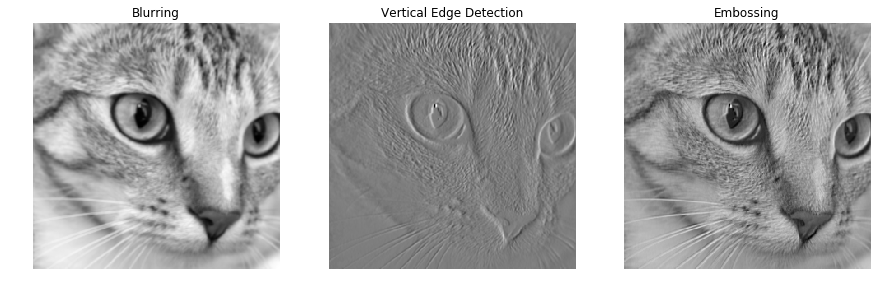

In [87]:
# Plot the filtered images
f = plt.figure(1, figsize=(15,5))

plt.subplot(131)
plt.imshow(cat_sq_blur, cmap='gray')
plt.title('Blurring')
plt.axis('off')

plt.subplot(132)
plt.imshow(cat_sq_ve, cmap='gray')
plt.title('Vertical Edge Detection')
plt.axis('off')

plt.subplot(133)
plt.imshow(cat_sq_emboss,cmap='gray')
plt.title('Embossing')
plt.axis('off')

plt.show()

>When convolved with an identity filter, all pixels values in the image stay the same. *Question: What would the identity filter be for a kernel size of 3x3?*

>Answer:

>*Question: What filter would shift all pixels in an image to right by one? (Hint : it looks very similar to the identity filter!)*

>Answer:

### 1.7 Effects of changing the kernel size
Of course, we're not limited to a 3x3 kernel. Going back to blurring an image, a larger blurring kernel means more blurring!

In [0]:
# 3x3 blurring kernel we already defined in Section 1.6
k3 = 1/9 * np.array([[1, 1, 1],
                     [1, 1, 1],
                     [1, 1, 1]])

# Change this to blur with a 5x5 kernel!
k5 = np.ones((5,5))/25


# Change this to blur with a 201x201 kernel!
k201 = np.ones((201,201))/(201**2)


cat_sq_3 = convolve2d(cat_sq, k3, mode='same', boundary='symm').astype('uint8')
cat_sq_5 = convolve2d(cat_sq, k5, mode='same', boundary='symm').astype('uint8')
cat_sq_201 = convolve2d(cat_sq, k201, mode='same', boundary='symm').astype('uint8')

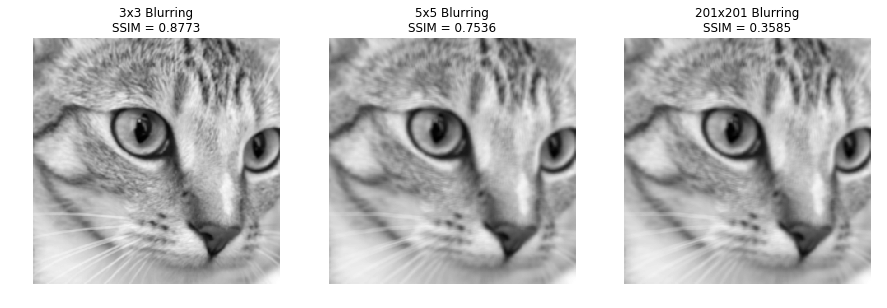

In [103]:
# Plot three levels of blurring
f = plt.figure(1, figsize=(15,5))

plt.subplot(131)
plt.imshow(cat_sq_3, cmap='gray')
plt.title('3x3 Blurring\nSSIM = '+str(np.around(compare_ssim(cat_sq,cat_sq_3),4)))
plt.axis('off')

plt.subplot(132)
plt.imshow(cat_sq_5, cmap='gray')
plt.title('5x5 Blurring\nSSIM = '+str(np.around(compare_ssim(cat_sq,cat_sq_5),4)))
plt.axis('off')

plt.subplot(133)
plt.imshow(cat_sq_5, cmap='gray')
plt.title('201x201 Blurring\nSSIM = '+str(np.around(compare_ssim(cat_sq,cat_sq_201),4)))
plt.axis('off')

plt.show()

### 1.8 Edge Detection (Optional)
A common problem for modern autonomous systems (like self-driving cars or robots) is object recognition. If we want to figure out whether an image contains a certain object, the first step is to find the edges of objects in the image since machines, like humans, rely heavily on edges to understand what they see. 

More specifically, we'd like to create a new image where large values (white or black pixels) correspond to pixels where we think there's an edge. We've already seen a kernel that can do this for vertical edges in Section 1.6. 

An edge in an image is usually defined by a sharp difference between adjacent pixels. If a kernel substracts values on one side of a pixel from values on the other, we have a simple edge detection kernel that's called a Sobel kernel. This kernel will output values near zero when adjacent pixels are similar, and large values when adjacent pixels are substantially different.

In [0]:
# Define two types of edge detection filters

# Vertical edge detection filter we already defined in Section 1.6
sobel_v = np.array([[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]])

# Fill in the values below to define a horizontal edge detection filter
# - Hint : there's a simple relationship between horizontal and vertical edges!
sobel_h = np.array([[1,2,1],
                    [0,0,0],
                    [-1,-2,-1]])

In [0]:
# Filter the cat image with vertical and horizontal edge detection filters
cat_sq_v = convolve2d(cat_sq, sobel_v, mode='same', boundary='symm')
cat_sq_h = convolve2d(cat_sq, sobel_h, mode='same', boundary='symm')

# Compute the combined edge magnitude of both edge directions
cat_sq_all = np.sqrt( cat_sq_v**2 + cat_sq_h**2 ) / np.sqrt(2)

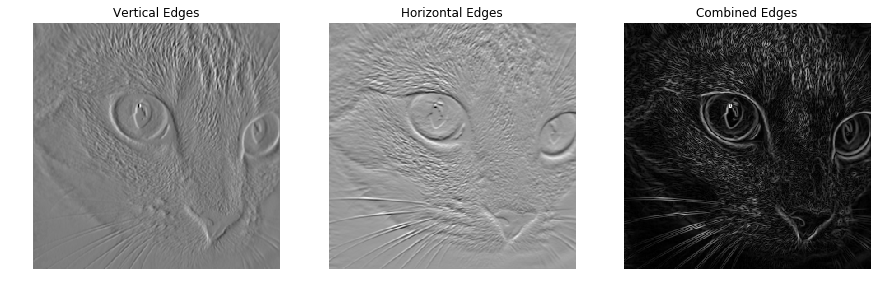

In [0]:
# Plot the vertical, horizontal, and combined edge-detected images
f = plt.figure(1, figsize=(15,5))

plt.subplot(131)
plt.imshow(cat_sq_v, cmap='gray')
plt.title('Vertical Edges')
plt.axis('off')

plt.subplot(132)
plt.imshow(cat_sq_h, cmap='gray')
plt.title('Horizontal Edges')
plt.axis('off')

plt.subplot(133)
plt.imshow(cat_sq_all, cmap='gray')
plt.title('Combined Edges')
plt.axis('off')

plt.show()

>*Question: What differences in the vertical and horizontal edge-detected images sticks out the most?*

>Answer:

>*Question: Do you notice anything weird happening in the combined edge image?*

>Answer:

## 2) Style Transfer
A pretty cool application of deep learning is to take the "style" of one image - things like color, texture, and patterns - and apply it to the "content" of a completely different image.
<br>Here's an example: 
<center><img src = "https://codelabs.developers.google.com/codelabs/tensorflow-style-transfer-android/img/c8b30d69a632f9a2.png"></center>
To do this, we use a machine learning model called a convolutional neural network which has access to a huge number of convolutional kernels. By looking at examples, it learns to change these kernels so that they are able to capture the features of a specific style image (style and content together). This is the training phase, at which point the network has learned to extract a lot of information from an image. At this point, we could do a lot of things with the network, like use it to see whether an image contains an animal and if so, what kind. <br>

**Style Transfer happens when we present a content image to a pre-trained network and encourage it to keep its structure while making changes to its texture and colour, thus altering its style to match that of a style image.**

#### You're ready to start making your own pastiche now!!

We have 5 content and 21 style images in the folders for you. Listed are a few of them:

<br>**Content**:

*   flowers.jpg
*   noise.jpg
*   shenyang.jpg
*   shenyang3.jpg
*   venice-boat.jpg

<br>**Style**:
*   candy.jpg
*   la_muse.jpg
*  rain_princess.jpg
*   shipwrek.jpg
*   starry_night.jpg




**Import required functions**

In [0]:
import os
import sys
sys.path.insert(0, '/content/HandsOnTech-master/HOT_Demo')
workingdir = '{}'.format(os.getcwd()) + '/HandsOnTech-master/HOT_Demo/'
import style_transfer

**Function for making subplots of images after style transfer**

In [0]:
## function to plot out the images
## DO NOT EDIT
def plot_imgs(content_image,style_image,new_img,cff,sff):
  f = plt.figure(1, figsize=(15,5))
  plt.subplot(131)
  plt.title('Content Image')
  if cff:
    content_image_npy = imread(workingdir+'images/content/'+content_image)
  else:
    content_image_npy = content_image
  plt.imshow(content_image_npy,cmap='gray')
  plt.axis('off')
  plt.subplot(132)
  plt.title('Style Image')
  if sff:
    style_image_npy = imread(workingdir+'images/21styles/'+style_image)
  else:
    style_image_npy = style_image
  plt.imshow(style_image_npy,cmap='gray')
  plt.axis('off')
  plt.subplot(133)
  plt.imshow(new_img)
  dp = ([pos for pos, char in enumerate(out_name) if char == '.'])
  plt.title(str(out_name[:dp[0]]))
  plt.axis('off')

**Style transfer using content and style images already provided**

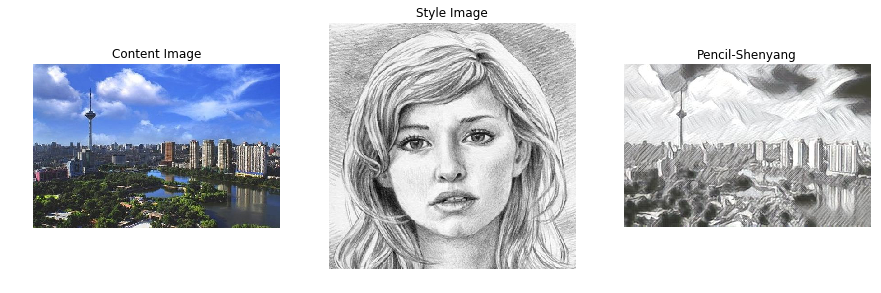

In [0]:
from style_transfer import magic_box

content_image = 'shenyang.jpg'
style_image = 'pencil.jpg'
out_name = 'Pencil-Shenyang.jpg'
cff = True #true if the content image is already in the content folder
sff = True #true if the style image is already in the 21styles folder 

new_img = style_transfer.magic_box(content_image,style_image,out_name,workingdir,cff,sff)
plot_imgs(content_image,style_image,new_img,cff,sff)

**Style transfer using a new content image (can be extended to use new style images too!)**

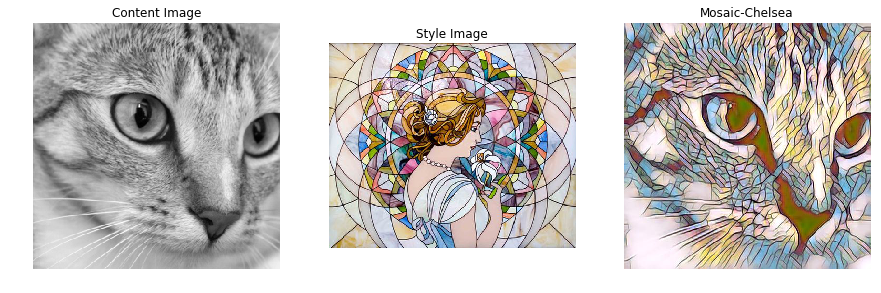

In [0]:
new_content = cat_sq ## to use a numpy.ndarray
# new_content = imread('img_name.jpg') ## to read in a new image

content_image = new_content
style_image = 'mosaic.jpg'
out_name = 'Mosaic-Chelsea.jpg'
cff = False #true if the style image is already in the content folder
sff = True #true if the style image is already in the 21styles folder

new_img = magic_box(content_image,style_image,out_name,workingdir,cff,sff)
plot_imgs(content_image,style_image,new_img,cff,sff)

**References:**
<br>**1.   PyTorch Multi-Style Transfer** (magic box): https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer 
<br>**2.   Convolution operation** (image 1): https://rohanverma.net/blog/2018/10/14/convolutional-neural-network-basics/ 
<br>**3. Convolutional kernel movement** (image 2): https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
<br>**4. Style transfer example** (image 3): https://codelabs.developers.google.com/codelabs/tensorflow-style-transfer-android/index.html#0



